Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 26)                0         
                                                                 
 dense (Dense)               (None, 1024)              27648     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Unrecognized location 'upper right '. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


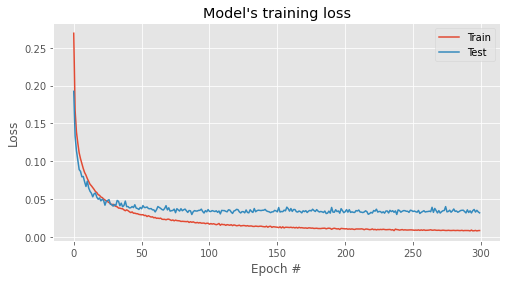

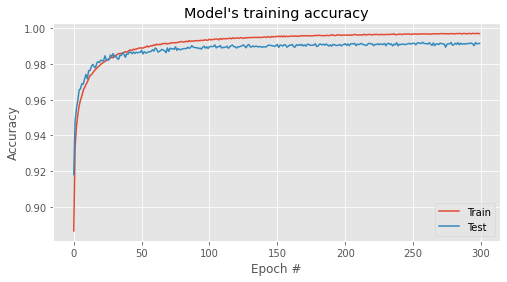

4666/4666 - 11s - loss: 0.0350 - accuracy: 0.9913 - 11s/epoch - 2ms/step

Test accuracy: 0.991346538066864
Target: 0, Predicted label: [0]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/Drone and No drone data combined.csv"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    data = pd.read_csv(DATA_PATH)

    X=np.array(data.iloc[:,:-1]).astype('float32')

    y=np.array(data.iloc[:,-1])
    return X, y


def plot_loss(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's training loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(['Train', 'Test'], loc='upper right ')
    plt.show()


def plot_accuracy(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model's training accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=input_shape),

        # 1st dense layer
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.1),

        # 2nd dense layer
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.1),

        # 3rd dense layer
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.15),

        # output layer
        keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))
    #tf.math.confusion_matrix(y, predicted_index)


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.30, 0.10)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    #optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=256, epochs=300)

    # save modal
    model.save("my_model2")
    # Serialize model to JSON:
    model_json = model.to_json()
    with open("drone1.json", "w") as json_file:
      json_file.write(model_json)

    # Serialize weights to HDF5 (h5py needed):
    model.save_weights("drone1_model.h5")
    print("Model saved to disk.")

    # plot accuracy/error for training and validation
    plot_loss(history)
    plot_accuracy(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict =X_test[100]

    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

In [ ]:
y_pred=model.predict(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
print(con_mat)

tf.Tensor(
[[38436     1]
 [34177 76690]], shape=(2, 2), dtype=int32)


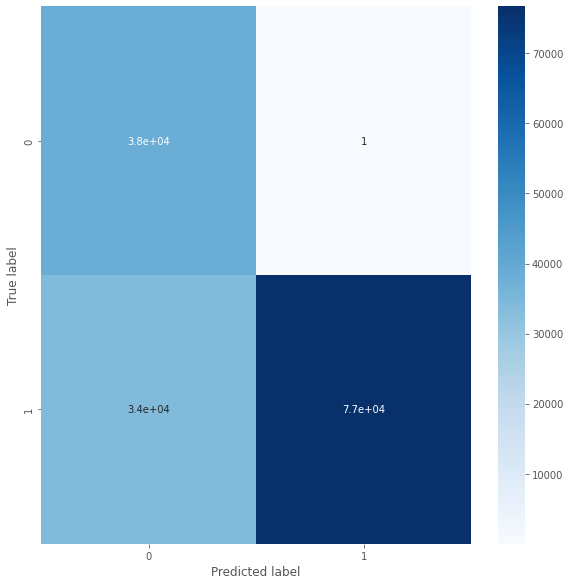

              precision    recall  f1-score   support

           0       0.53      1.00      0.69     38437
           1       1.00      0.69      0.82    110867

    accuracy                           0.77    149304
   macro avg       0.76      0.85      0.76    149304
weighted avg       0.88      0.77      0.79    149304



In [ ]:
y_pred=model.predict(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred.astype(int)))